In [1]:
using DataFrames, CSV, Plots, Statistics, Query, Pipe, Indicators

In [2]:
df = CSV.File("HIST_PAINEL_COVIDBR_2021_Parte1_27ago2021.csv") |> DataFrame;
@pipe CSV.File("HIST_PAINEL_COVIDBR_2021_Parte2_27ago2021.csv") |> DataFrame |> append!(df, _)
first(df, 5)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data
,String,String?,String?,Int64,Int64?,Int64?,String?,Date…
1,Brasil,missing,missing,76,missing,missing,missing,2021-01-01
2,Brasil,missing,missing,76,missing,missing,missing,2021-01-02
3,Brasil,missing,missing,76,missing,missing,missing,2021-01-03
4,Brasil,missing,missing,76,missing,missing,missing,2021-01-04
5,Brasil,missing,missing,76,missing,missing,missing,2021-01-05


In [3]:
# SC only for this test

df = df |>
        @filter(_.estado == "SC") |>
        DataFrame

first(df, 10)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data
,String,String?,String?,Int64,Int64?,Int64?,String?,Date…
1,Sul,SC,missing,42,missing,missing,missing,2021-01-01
2,Sul,SC,missing,42,missing,missing,missing,2021-01-02
3,Sul,SC,missing,42,missing,missing,missing,2021-01-03
4,Sul,SC,missing,42,missing,missing,missing,2021-01-04
5,Sul,SC,missing,42,missing,missing,missing,2021-01-05
6,Sul,SC,missing,42,missing,missing,missing,2021-01-06
7,Sul,SC,missing,42,missing,missing,missing,2021-01-07
8,Sul,SC,missing,42,missing,missing,missing,2021-01-08
9,Sul,SC,missing,42,missing,missing,missing,2021-01-09


In [4]:
size(df)[1]

70983

In [5]:
names(df)

17-element Vector{String}:
 "regiao"
 "estado"
 "municipio"
 "coduf"
 "codmun"
 "codRegiaoSaude"
 "nomeRegiaoSaude"
 "data"
 "semanaEpi"
 "populacaoTCU2019"
 "casosAcumulado"
 "casosNovos"
 "obitosAcumulado"
 "obitosNovos"
 "Recuperadosnovos"
 "emAcompanhamentoNovos"
 "interior/metropolitana"

In [6]:
dfcasos = df |> 
            @groupby({_.data}) |>
            @map({data=key(_)[1], casos=sum(_.casosNovos)}) |>
            DataFrame

first(dfcasos, 10)

,data,casos
,Date…,Int64
1,2021-01-01,3728
2,2021-01-02,4154
3,2021-01-03,1642
4,2021-01-04,3130
5,2021-01-05,7750
6,2021-01-06,8224
7,2021-01-07,8864
8,2021-01-08,7760
9,2021-01-09,7192


In [7]:
gr()

Plots.GRBackend()

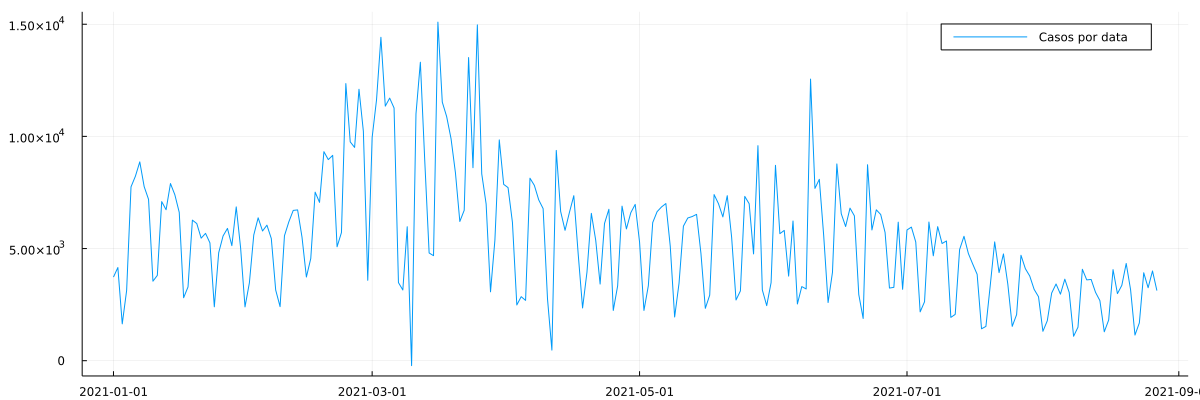

In [8]:
plot(dfcasos.data, dfcasos.casos, size=(1200, 400), label="Casos por data")

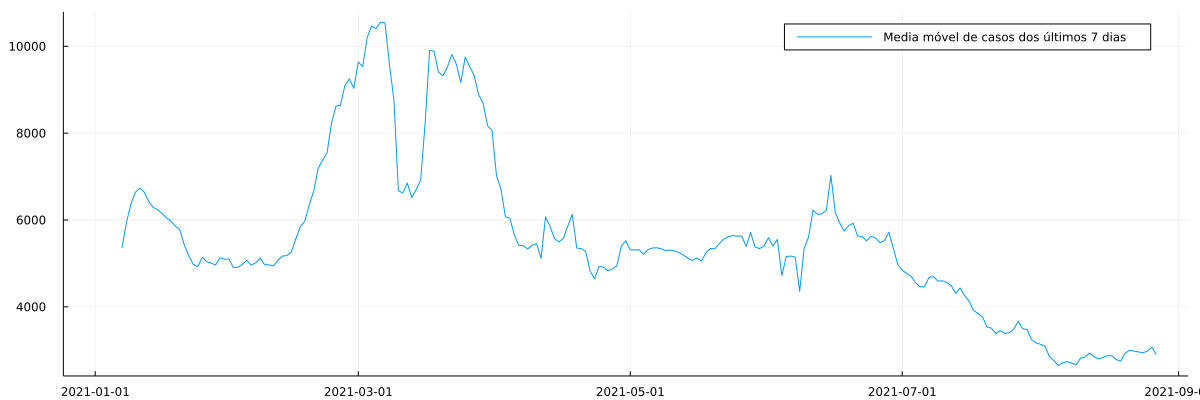

In [9]:
plot(dfcasos.data, sma(dfcasos.casos, n=7), size=(1200, 400), label="Media móvel de casos dos últimos 7 dias")

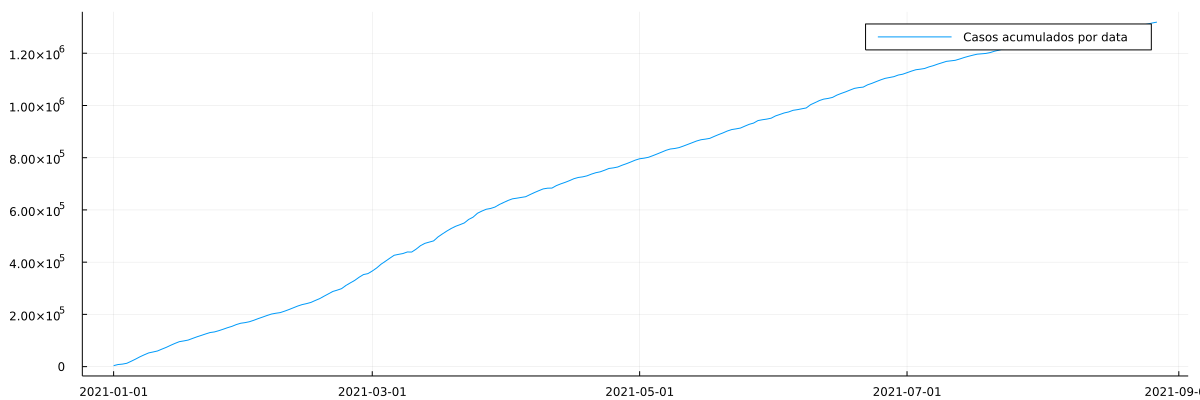

In [10]:
plot(dfcasos.data, cumsum(dfcasos.casos), size=(1200, 400), label="Casos acumulados por data")

In [11]:
vaxdf = CSV.File("vacinados_sc.csv") |> DataFrame
first(vaxdf, 10)

,estado,data,parcial,total
,String,Date…,Int64,Int64
1,SC,2021-01-17,12,2
2,SC,2021-01-18,9,3
3,SC,2021-01-19,2700,5
4,SC,2021-01-20,13713,23
5,SC,2021-01-21,11965,17
6,SC,2021-01-22,6842,45
7,SC,2021-01-23,970,2
8,SC,2021-01-24,245,4
9,SC,2021-01-25,5269,12


In [12]:
dfcasos = dfcasos |>
            @orderby(_.data) |>
            @join(vaxdf, _.data, _.data, {_.data, _.casos, __.parcial, __.total}) |>
            DataFrame

first(dfcasos, 10)

,data,casos,parcial,total
,Date…,Int64,Int64,Int64
1,2021-01-17,2806,12,2
2,2021-01-18,3288,9,3
3,2021-01-19,6266,2700,5
4,2021-01-20,6114,13713,23
5,2021-01-21,5462,11965,17
6,2021-01-22,5676,6842,45
7,2021-01-23,5252,970,2
8,2021-01-24,2402,245,4
9,2021-01-25,4814,5269,12


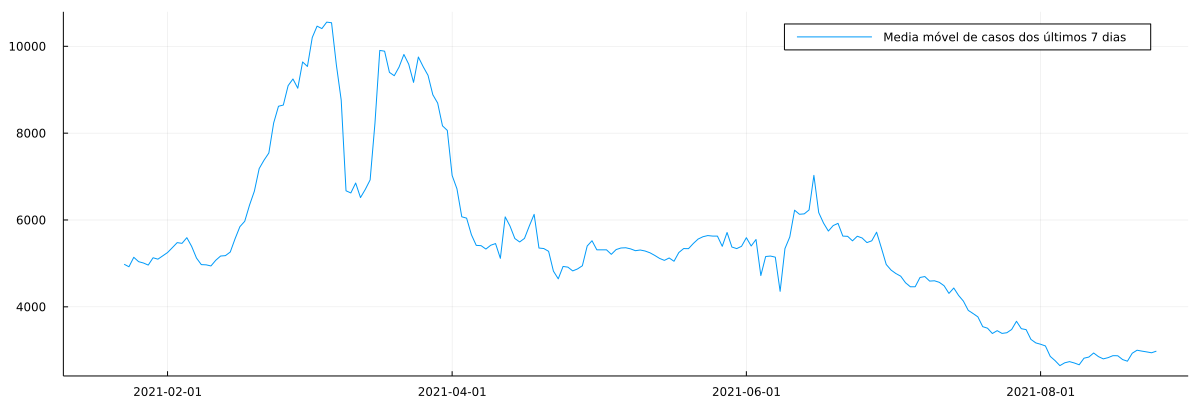

In [13]:
plot(dfcasos.data, sma(dfcasos.casos, n=7), size=(1200, 400), label="Media móvel de casos dos últimos 7 dias")

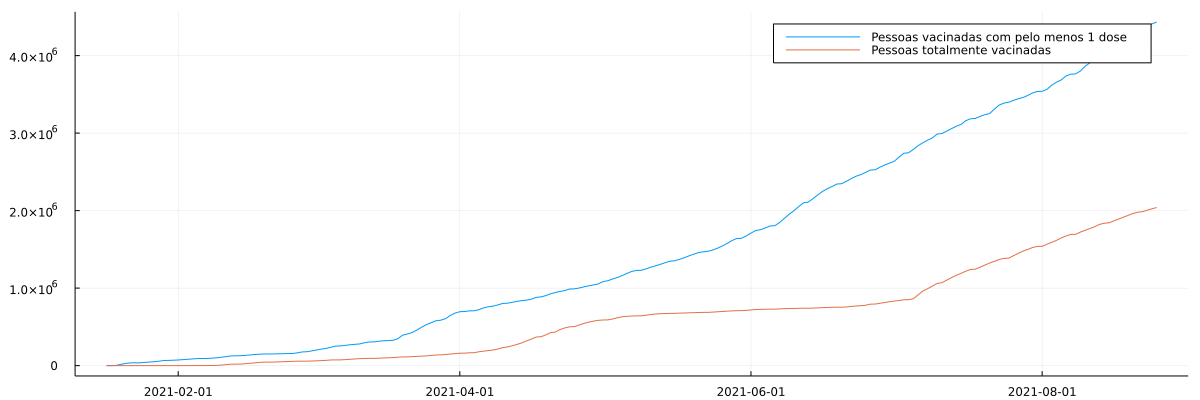

In [14]:
plot(dfcasos.data, cumsum(dfcasos.parcial), size=(1200, 400), label="Pessoas vacinadas com pelo menos 1 dose")
plot!(dfcasos.data, cumsum(dfcasos.total), label="Pessoas totalmente vacinadas")

In [22]:
correlation = cor(Matrix(dfcasos[:, 2:4]))

3×3 Matrix{Float64}:
  1.0        -0.0280816  -0.246531
 -0.0280816   1.0         0.480717
 -0.246531    0.480717    1.0

In [24]:
r2 = correlation[1,3]^2

0.060777642642386616